In [1]:
%matplotlib notebook

In [44]:
import biff
import sys
sys.path.append('../')
import coefficients_smoothing
import pygadgetreader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import jellyfish

In [30]:
font = {'size':5, 'family':'serif'}
matplotlib.rc('font', **font)

In [6]:
def load_density(dens_fname, nbins):
    rho_mwlmc = np.loadtxt(dens_fname)
    rho_matrix = np.reshape(rho_mwlmc, (nbins, nbins, nbins))
    return rho_matrix



In [7]:
densities1 = '../rhomwlmc.txt'

#densities = 'mw_bfe_density_SN_0_snap_000.txt'
rho1 = load_density(densities1, 120)


In [9]:
np.shape(rho1)

(120, 120, 120)

In [10]:
x_grid = np.arange(-300, 300, 5)
y_grid = np.arange(-300, 300, 5)
z_grid = np.arange(-300, 300, 5)
x_grid, y_grid, z_grid = np.meshgrid(x_grid, y_grid, z_grid)


In [11]:
np.max(rho1)

nan

In [12]:
print(np.nanmax(rho1), np.nanmin(rho1))

1436.0427614734735 -0.0017669672068963563


In [13]:
density_contours = np.logspace(np.nanmin(np.log10(rho1)), np.nanmax(np.log10(rho1)), 10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [14]:
density_contours

array([1.53612542e-08, 2.54330160e-07, 4.21084303e-06, 6.97172489e-05,
       1.15428069e-03, 1.91109650e-02, 3.16412627e-01, 5.23871769e+00,
       8.67353597e+01, 1.43604276e+03])

In [15]:
index_dens1 = np.where((rho1>density_contours[-2]-density_contours[-2]*0.3) & ((rho1<density_contours[-2]+density_contours[-2]*0.3)))
index_dens2 = np.where((rho1>density_contours[-3]-density_contours[-3]*0.1) & ((rho1<density_contours[-3]+density_contours[-3]*0.1)))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [17]:
print(np.shape(index_dens1), np.shape(index_dens2))

(3, 574) (3, 3119)


<IPython.core.display.Javascript object>


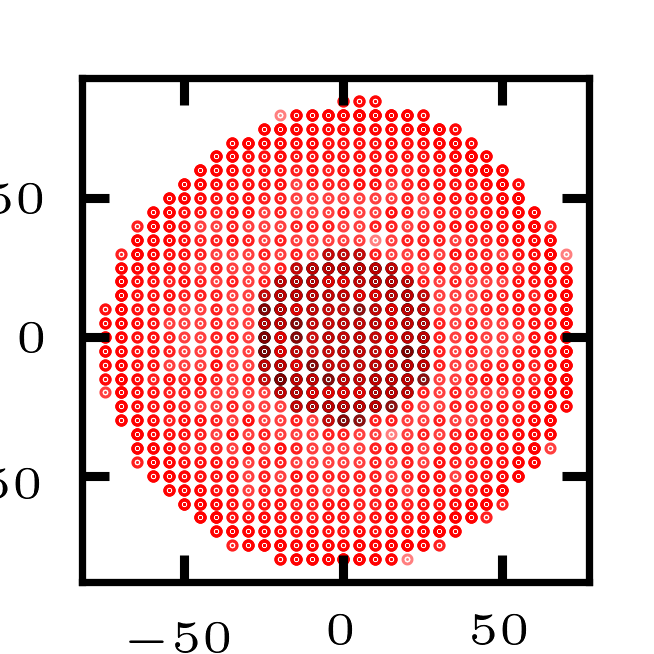

In [32]:
plt.figure(figsize=(1,1))
plt.scatter(x_grid[index_dens1], y_grid[index_dens1], s=0.1, alpha=0.5, c='k')
plt.scatter(x_grid[index_dens2], y_grid[index_dens2], s=0.1, alpha=0.5, c='r')


In [33]:
x_grid[index_dens2]

array([-20, -20, -20, ...,  10,  10,  10])

In [68]:
np.hstack?

Signature: np.hstack(tup)
Docstring:
Stack arrays in sequence horizontally (column wise).

This is equivalent to concatenation along the second axis, except for 1-D
arrays where it concatenates along the first axis. Rebuilds arrays divided
by `hsplit`.

This function makes most sense for arrays with up to 3 dimensions. For
instance, for pixel-data with a height (first axis), width (second axis),
and r/g/b channels (third axis). The functions `concatenate`, `stack` and
`block` provide more general stacking and concatenation operations.

Parameters
----------
tup : sequence of ndarrays
    The arrays must have the same shape along all but the second axis,
    except 1-D arrays which can be any length.

Returns
-------
stacked : ndarray
    The array formed by stacking the given arrays.

See Also
--------
stack : Join a sequence of arrays along a new axis.
vstack : Stack arrays in sequence vertically (row wise).
dstack : Stack arrays in sequence depth wise (along third axis).
concatenate 

In [171]:
def ellipsoid_plot(center, radii, rotation, ax, plot_axes=False, cage_color='b', cage_alpha=0.2):
    """Plot an ellipsoid"""
    # Function taken from https://github.com/aleksandrbazhin/ellipsoid_fit_python/ellipsoid_fit.py
        
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    
    # cartesian coordinates that correspond to the spherical angles:
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    # This is the magic!! 
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation) + center

    if plot_axes:
        # make some purdy axes
        axes = np.array([[radii[0],0.0,0.0],
                         [0.0,radii[1],0.0],
                         [0.0,0.0,radii[2]]])
        # rotate accordingly
        for i in range(len(axes)):
            axes[i] = np.dot(axes[i], rotation)

        # plot axes
        for p in axes:
            X3 = np.linspace(-p[0], p[0], 100) + center[0]
            Y3 = np.linspace(-p[1], p[1], 100) + center[1]
            Z3 = np.linspace(-p[2], p[2], 100) + center[2]
            ax.plot(X3, Y3, Z3, color=cage_color)

    # plot ellipsoid
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cage_color, alpha=cage_alpha)

def points_ellipsoid(center, radii, rotation, n_points):
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    
    # cartesian coordinates that correspond to the spherical angles:
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation) + center


In [78]:
tensor = jellyfish.shape_tensor(np.array([x_grid[index_dens2], y_grid[index_dens2]*0.5, z_grid[index_dens2]*0.2]).T)

In [79]:
tensor

array([[5449525.,  145200.,  -20820.],
       [ 145200., 1770300.,  -40675.],
       [ -20820.,  -40675.,  245381.]])

In [80]:
eigval, eigvec = np.linalg.eig(tensor)

In [81]:
print(eigval**0.3/2)
print(eigvec)

[52.48275409 37.41444463 20.66882814]
[[ 0.99921351  0.03951839  0.0032638 ]
 [ 0.03941901 -0.99887571  0.0263337 ]
 [-0.0043008   0.02618434  0.99964788]]


<IPython.core.display.Javascript object>


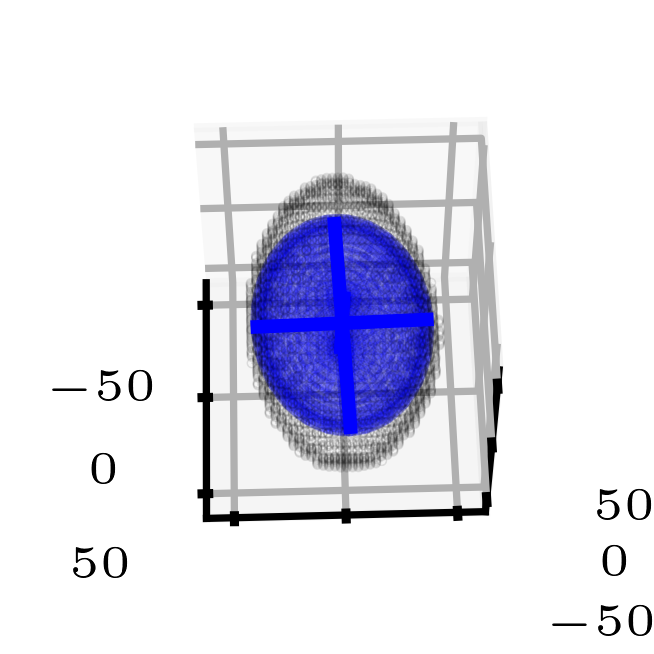

In [111]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
ax.scatter(x_grid[index_dens2], y_grid[index_dens2]*0.5, z_grid[index_dens2]*0.2, marker='.', color='k', s=0.1, alpha=0.1)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)
ellipsoid_plot(np.array([0,0,0]), eigval**0.3/2, eigvec.T, ax, plot_axes=True, cage_color='b', cage_alpha=0.2)

<IPython.core.display.Javascript object>


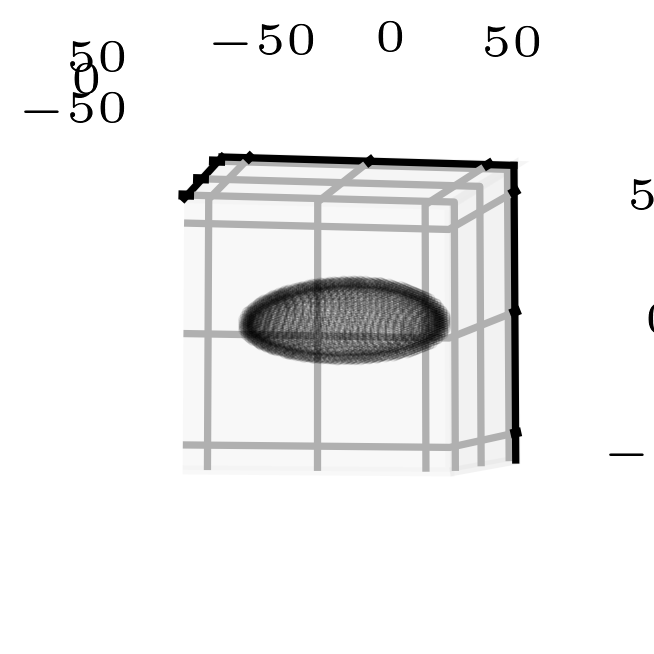

(-60, 60)

In [86]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
ax.scatter(x_grid[index_dens2], y_grid[index_dens2]*0.5, z_grid[index_dens2]*0.2, marker='.', color='k', s=0.1, alpha=0.1)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

In [161]:
def y_rotation(vector,theta):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[0, np.cos(theta),np.sin(theta)],[1,0,0],[0, -np.sin(theta), np.cos(theta)]])
    return np.dot(R,vector)

In [166]:
xyz_rot = y_rotation(np.array([x_grid[index_dens2], y_grid[index_dens2]*0.5, z_grid[index_dens2]]), -np.pi/4.)

<IPython.core.display.Javascript object>


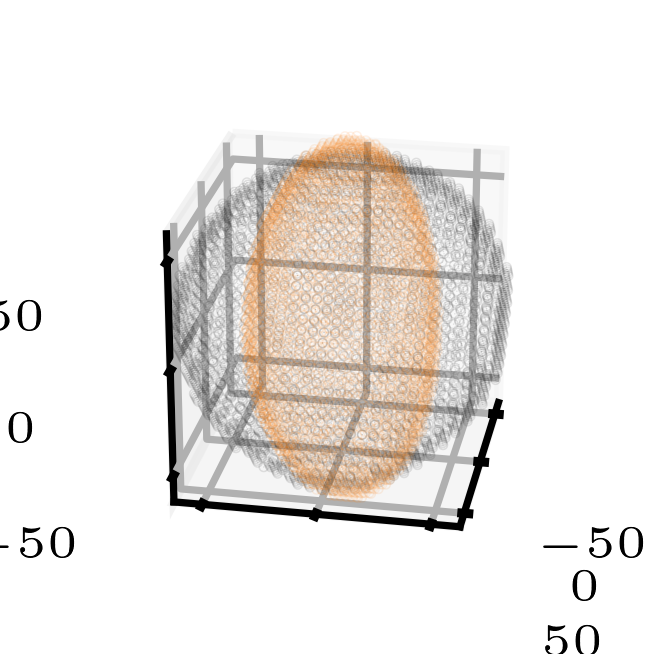

Text(0.5,0,'x')

In [167]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
ax.scatter(xyz_rot[0], xyz_rot[1], xyz_rot[2], marker='.', color='k', s=0.1, alpha=0.1)
ax.scatter(x_grid[index_dens2], y_grid[index_dens2]*0.5, z_grid[index_dens2], marker='.', color='C1', s=0.1, alpha=0.1)

ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)
plt.xlabel('x', fontsize=10)


In [168]:
tensor_rot = jellyfish.shape_tensor(xyz_rot.T)
eigval_rot, eigvec_rot = np.linalg.eig(tensor_rot)

<IPython.core.display.Javascript object>


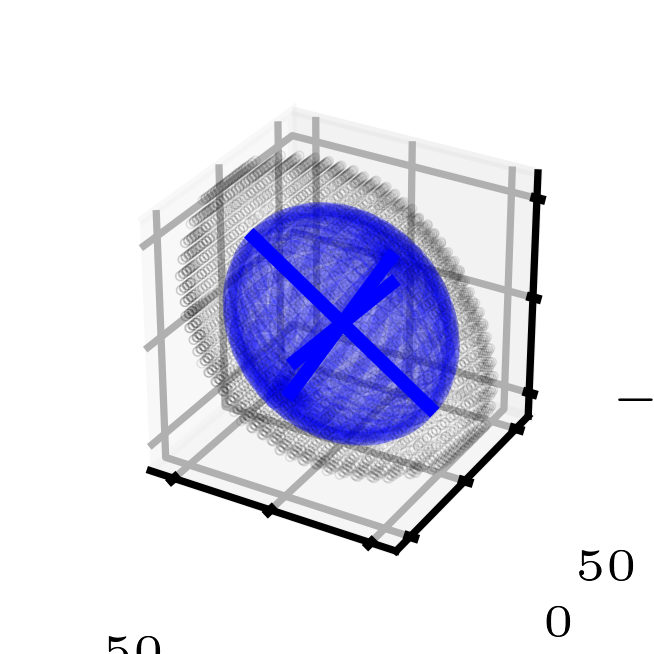

In [172]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
ax.scatter(xyz_rot[0], xyz_rot[1], xyz_rot[2], marker='.', color='k', s=0.1, alpha=0.1)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)
plt.xlabel('x', fontsize=10)
pos_fit = ellipsoid_plot(np.array([0,0,0]), eigval_rot**0.3/2, eigvec_rot.T, ax, plot_axes=True, cage_color='b', cage_alpha=0.2)


In [170]:
def likelihood(pos, pos_fit):
    r_data = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    r_fit = np.sqrt(pos_fit[:,0]**2 + pos_fit[:,1]**2 + pos_fit[:,2]**2)
    L = -0.5 * np.sum(r_data-r_fit)**2
    

In [174]:
likelihood(xyz_rot.T, pos_fit)

ValueError: operands could not be broadcast together with shapes (3119,) (100,3) 

In [175]:
xyz_rot.any?